# Logical flow to train a 'tracks-to-KDE' model: 

This notebook presents the main steps used to train a 'tracks-to-KDE' model. These steps are briefly described below with additional comments throughout the notebook. 

We assume that the data has been prepared using the <strong>Make_HDF5_files_from_ROOT_files.py</strong> script in folder <strong>pv-finder_v2/scripts</strong>.

<ul>
 <li><strong>Machine selection</strong></li>
 <li><strong>Configuration file import</strong></li>
    All configurable parameters are defined in this yaml file, which is passed along to (or directly accessed in) all the methods used here.
 <li><strong>Local setups</strong></li>
    <ul>
      <li>Setting list of input files and corresponding slices</li>
      <li>Definition of the input tag (will be used to identify the data to be used)</li>
      <li>Definition of the output tag (unique identification tag for this training)</li>
      <li>Definition of the output folders (combination of the input and output tags)</li>
    </ul>        
 <li><strong>Data import </strong></li>
    Two options are available on how to import data
    <ul>
      <li> Reading in the HDF5 file and building the pytorch tensors on the flight</li>
      <li> Reading in pytorch tensors directly from disk (see Tutorial_Data_Manipulation.ipynb) </li>
    </ul>        
 <li><strong>Model preparation </strong></li>
    Multiple tasks actually performed here:
    <ul>
      <li> NN instantiation (currently Fully Connected NN with 6 layers)</li>
      <li> Optimizer instantiation (either ADAM or SGD currently implemented)</li>
      <li> Loss function instantiation (for 'tracks-to-KDE' model using a MSE-like function)</li>
    </ul>        
 <li><strong>Model training </strong></li>
    For each training several outputs are saved:
    <ul>
      <li> weights after each iteration</li>
      <li> plot showing the training and validation costs evolution as a function of the epcoh number</li>
    </ul>        
 <li><strong>Model testing </strong></li>
    The cost function value cannot be used blindly to identify a well trained model, and visual inspection of the model predictions versus truth is essential. For the 'tracks-to-KDE' model, testing the model allows to compare the predicted and true distributions in relevant intervals as well as for entire events.<br>
    <strong>Note:</strong> Since most of intervals are empty of tracks (i.e KDE activity), only intervals with a prediction or a target KDE above a certain threshold are plotted.
 </ul>



In [1]:
%matplotlib notebook

#  ___
#  STEP 0: select machine

Select device from list of available GPU

In [2]:
!nvidia-smi

Mon Nov 20 06:29:02 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB           Off| 00000000:01:00.0 Off |                    0 |
| N/A   20C    P0               31W / 250W|      0MiB / 40960MiB |      0%      Default |
|                                         |                      |             Enabled* |
+-----------------------------------------+----------------------+--

In [3]:
from utils.utilities import select_gpu
device = select_gpu(2)

1 available GPUs (initially using device 0):
  0 NVIDIA A100-PCIE-40GB


#  ___
#  STEP 1: import of the configuration file

In [4]:
## ------------------------------
## Import the configuration file
import yaml

CONFIG_FILES_DIR = '/data/home/sakar/pv-finder_v2/configs/'

CONFIG_FILE = CONFIG_FILES_DIR + 'configuration_default_T2KDE.yaml'

with open(CONFIG_FILE, 'r') as f:
    configs = yaml.load(f, Loader=yaml.FullLoader)
    
## Get the considered experiement: LHCb / ATLAS / CMS...
EXP = configs['Experiment']
    
## Get the global configuration (one for each experiment, selected based on the --experiment argument)    
global_configs = configs['global_configs'][EXP]

In [5]:
## ------------------------------
## Print the configuration file:
import pprint
for key in configs.keys():
    if "global_configs" in key:
        print("")
        print("*"*100)
        print("\x1b[33;40m %s[%s] \x1b[0m:"%(key,configs["Experiment"]))
        print("")
        pprint.pprint(configs["global_configs"][configs["Experiment"]], indent=10)
    else:
        print("")
        print("*"*100)
        print("\x1b[33;40m %s \x1b[0m:"%key)
        print("")
        pprint.pprint(configs[key], indent=10)


****************************************************************************************************
 Experiment :

'LHCb'

****************************************************************************************************
 global_configs[LHCb] :

{         'A_res': 926.0,
          'B_res': 0.84,
          'C_res': 10.7,
          'MaxPOCA': 100000,
          'MinPOCA': 1e-10,
          'doIntervals': True,
          'epsilon_KDE': 0.001,
          'intervalExtension': 2.5,
          'maxSigmaX': 4.0,
          'maxSigmaY': 4.0,
          'maxSigmaZ': 2.0,
          'maxTracksPerInterval': 250,
          'nBinsPerInterval': 100,
          'n_bins_poca_kde': 4000,
          'n_tracks_valid_PVs': 5,
          'res_min_target': 0.15,
          'scaleFactor_IP_KDE': 2500,
          'scaleFactor_poca_KDE_A': 1000,
          'scaleFactor_poca_KDE_B': 10000,
          'tracks_default_POCA': -99.0,
          'z_max': 300.0,
          'z_min': -100.0}

**************************************

#  ___
#  STEP 2: input and outputs definitions

In [6]:
from utils.utilities import getDataTagName, getTrainTagName, makeOutPutFolders

## Retrieve the data location folder from configuration file
data_root = configs['data_processing_configs']['output_files_path']

## Example of list of HDF5 files to be used
## This approach allows to used different type of input:
## e.g. minimum bias and B decays for instance
## In this example, we use several hdf5 files build from unique root files.
l_HDF_files = [data_root + "/" + "pv_HLT1CPU_MinBiasMagUp_1__validPVs_5tracks__Intervals_100bins.hdf5",
               data_root + "/" + "pv_HLT1CPU_MinBiasMagUp_2__validPVs_5tracks__Intervals_100bins.hdf5",
               data_root + "/" + "pv_HLT1CPU_MinBiasMagUp_3__validPVs_5tracks__Intervals_100bins.hdf5",
               data_root + "/" + "pv_HLT1CPU_MinBiasMagUp_4__validPVs_5tracks__Intervals_100bins.hdf5",
               data_root + "/" + "pv_HLT1CPU_MinBiasMagUp_4__validPVs_5tracks__Intervals_100bins.hdf5",
              ]

## Example of list of tensors stored on disk
## Note that here only the prefix for the file name is 
## used as for each hdf5 file three ".pt" (pytorch tensors)
## are created using the scripts/Build_Torch_Tensors.py
## script.
## This approach allows to used different type of input:
## e.g. minimum bias and B decays for instance
l_tensor_files = [data_root + "/" + "pv_HLT1CPU_MinBiasMagUp_1__validPVs_5tracks__Intervals_100bins",
                  data_root + "/" + "pv_HLT1CPU_MinBiasMagUp_2__validPVs_5tracks__Intervals_100bins",
                  data_root + "/" + "pv_HLT1CPU_MinBiasMagUp_3__validPVs_5tracks__Intervals_100bins",
                  data_root + "/" + "pv_HLT1CPU_MinBiasMagUp_4__validPVs_5tracks__Intervals_100bins",
                  data_root + "/" + "pv_HLT1CPU_MinBiasMagUp_4__validPVs_5tracks__Intervals_100bins",
                 ]

## For each file, one can associate a corresponding slice 
## IMPORTANT:: Slice are a function of the number of events to be used
##             If using intervals, these are automatically converted into 
##             number of intervals (using values in config file)
l_slices_events = [slice(0,-1),
                   slice(0,-1),
                   slice(0,-1),
                   slice(0,300),
                   slice(300,-1),
                  ]

# Define tag for this notebook.
# It will be used to tag output of training
data_tag = "pv_HLT1CPU_MinBiasMagUp_config_alpha"
# Update the tag according to the data processing paramaters
data_tag = getDataTagName(data_tag, global_configs)

# Definfe tag from training options to output tag (used to identify training specifications)
train_tag = getTrainTagName(configs)
# Define an arbitrary output tag suffix: 
# this is a free tag to help user distinguishing 
# different trainings with same training options 
# e.g. 'iterXX'
train_tag += "__YOUR_TAG_tutorial"

# Create the structure of the output folders used to store the training outputs:
# - outPutFolder_weights: where the training weights are stored
# - outPutFolder_plots: where the training and testing plots are stored
outPutFolder_weights, outPutFolder_plots = makeOutPutFolders(data_tag, train_tag, configs, CONFIG_FILE)

#  ___
#  STEP 3: data import

Two methods can be used to collect data: 

<ul>
  <li> <strong><em>collectData_fromHDF</em></strong>: Reading in the HDF5 file and building the pytorch tensors on the flight</li>
  <li> <strong><em>collectData_fromTensor</em></strong>: Reading in pytorch tensors directly from disk</li>
</ul>        
The former is slower as buidling pytorch tensors can take a few minutes depending on the size of the input data (i.e. number of events considered), but it allows better memory disk usage as the tensors, in case of large data sets, can be large (several GB)!
The latter option obsviously assumes that the pytorch tensors have previously been created and stored on disk. 
This has to be done using <strong><em>Build_Torch_Tensors.py</strong></em> in <strong><em>scripts</strong></em>.


<strong>Important note A</strong>: <br>
In both methods, the input file should be arranged in a list (see  <strong><em>STEP 2</strong></em>), together with a list of slices allowing to use any amount of events in a given input file.
If using multiple files, the collectData methods will merge the data tensors from each file into a unique output data loader. 
For the moment no shuffling can be applied, and events from multiple files will simply be concatenated.

<strong>Important note B</strong>: <br>
The default setting for the data collection through either <strong><em>collectData</em></strong> method is that three datasets are returned: training, validation and testing. The fraction of events to be used to form these three datasets can be modified in the configuration file from: <br> 
\---> configs["training_configs"]["train_split"] = [80%, 10%, 10%] (by default) <br> <br> 
It is possible to disable the data splitting from the option argument <strong><em>split</em></strong> of either collectData methods and setting it to <strong><em>False</strong></em>. This allows for instance to use another HDF5 file (e.g. magUp versus magDown) for validation and testing.

<strong>Important note C</strong>: <br>
Choice of input and target data are automatically performed from the <strong><em>model_class</strong></em> parameter in the configuration file.

<strong>Important note D</strong>: <br>
The batch size is defined when building the data loader from the pytorch tensors and is configurable from the congiuration file.  <br>
Default is <strong>batch_size: 32</strong>

<strong>Important note E</strong>: <br>
In this tutorial, the data sample collected is very small (few hundred of events) and is simply for illustration. When performing training of the model, one should consider using tens of thousands of events, which will make each step below slower...

In [7]:
from utils.utilities import collectData_fromTensor, collectData_fromHDF

## Creating datasets using ---> <strong><em>collectData_fromHDF</strong></em>: 

In [8]:
train_loader, valid_loader, test_loader = collectData_fromHDF(configs, 
                                                              l_HDF_files,
                                                              l_slices_events,
                                                              split=True,
                                                              verbose=False)


****************************************************************************************************
****************************************************************************************************

   `-->  /data/home/sakar/ML_dir//pv_HLT1CPU_MinBiasMagUp_1__validPVs_5tracks__Intervals_100bins.hdf5

----------------------------------------------------------------------------------------------------



Splitting dataset with original slice_evts(0,669)
according to the following fractions: 0.80 (train) / 0.10 (validation) / 0.10 (test)

Sizes of split samples [events]: 535 (train) / 66 (validation) / 66 (test)

Last 2.0 event(s) discarded due to rounding...
This corresponds to 0.299 % percent of full data.


Sizes of split samples [intervals]: 21400 (train) / 2640 (validation) / 2640 (test)

 ==> took 1.045 s

****************************************************************************************************
*************************************************************************

### Datasets can be created from the <strong><em>collectData_fromTensor</strong></em> method! 
The <strong><em>collectData_fromTensor</strong></em> method takes the same arguments as the <strong><em>collectData_fromHDF</strong></em> one.
Please have a look into the <strong>Tutorial_Data_Manipulation</strong> notebook to see some examples.

#  ___
#  STEP 4: model preparation (along with optimizer and loss function)

All parameters related to the model, optimizer and loss function are configurable directly from the configuration file!

In [9]:
from utils.models_utils import prepare_model

In [10]:
model, loss, opt = prepare_model(configs, device)

****************************************************************************************************
Initializing the FCN6L model


with the following parameters:

   - n_InputFeatures  = 9
   - n_OutputFeatures = 100
   - l_HiddenNodes    = [20, 20, 20, 20, 20]
   - LeakyReLU_param  = 0.01
   - maskVal          = -99.0
   - predScaleFactor  = 0.001

****************************************************************************************************
****************************************************************************************************
Initializing the Optimizer


with the following parameters:

   - Optimizer type  = Adam
   - Learning rate   = 1e-05

****************************************************************************************************
****************************************************************************************************
Initializing the Loss using built in Chi^2 function

with the following parameters:

   - Epsilon    = 1e-05
   - nBins (for

#  ___
#  STEP 5: model training

All parameters related to model training are configurable directly from the configuration file!

During the training, after each epcoh the corresponding weights are saved in <strong>outPutFolder_weights</strong>.
<br>
At the end of the training the weights corresponding to the last epoch are copied into a file with suffix <strong>"_final"</strong>.
At the end of the training the plot showing the training and validation cost evolution saved in <strong>outPutFolder_plots</strong>.

In this tutorial, the training starts from random weights.

In [11]:
from utils.training_utils import train_model

<IPython.core.display.Javascript object>


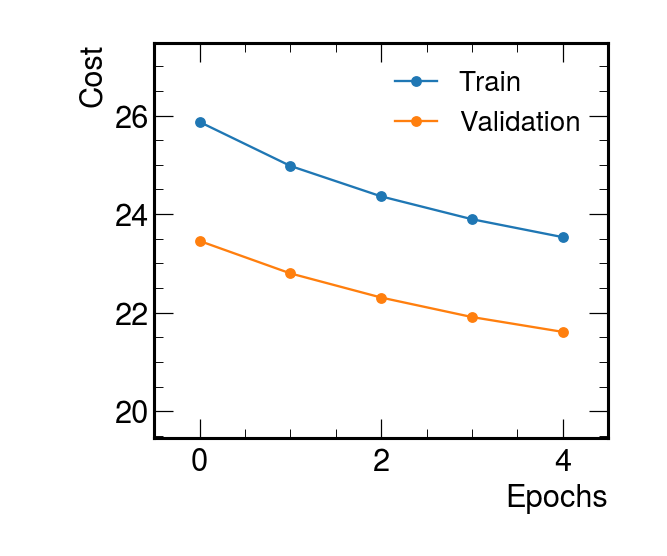

Number of batches: train = 2598, val = 322


Epochs:   0%|                                                                                                 …

Number of batches: train = 2598, val = 322


Training:   0%|                                                                                               …

Epoch 0: train=25.8695, val=23.4561, took 10.532 s


Training:   0%|                                                                                               …

Epoch 1: train=24.9774, val=22.7981, took 12.89 s


Training:   0%|                                                                                               …

Epoch 2: train=24.3601, val=22.3082, took 13.207 s


Training:   0%|                                                                                               …

Epoch 3: train=23.8969, val=21.9129, took 11.928 s


Training:   0%|                                                                                               …

Epoch 4: train=23.5333, val=21.6118, took 12.608 s

****************************************************************************************************
Saving model weights from final iteration in:

/data/home/sakar/ML_dir/pv_HLT1CPU_MinBiasMagUp_config_alpha__validPVs_5tracks__Intervals_100bins/tracks-to-KDE__IntervalsTrue__5Epochs__BatchSize32__YOUR_TAG_tutorial/weights/train_epoch_final.pyt

****************************************************************************************************
Saving training plots in:

/data/home/sakar/ML_dir/pv_HLT1CPU_MinBiasMagUp_config_alpha__validPVs_5tracks__Intervals_100bins/tracks-to-KDE__IntervalsTrue__5Epochs__BatchSize32__YOUR_TAG_tutorial/plots

****************************************************************************************************


In [12]:
train_model(model, loss, opt, train_loader, valid_loader, configs, outPutFolder_weights, outPutFolder_plots)

#  ___
#  STEP 6: model testing and visual inspection of the performances

In order to get an idea of the performances after a training, one can check the distributions of the predictions versus the labels. This is done on an independent set of data if using the default data splitting from collectData.

In this tutorial, the first training is done on a small sample, with very few epochs, so the performances are not expected to be good at this point!



In [13]:
from utils.testing_utils import test_model

****************************************************************************************************

 Event (0) 

 Event (0) -- Interval (9) -- ymax ( 0.17) 


<IPython.core.display.Javascript object>


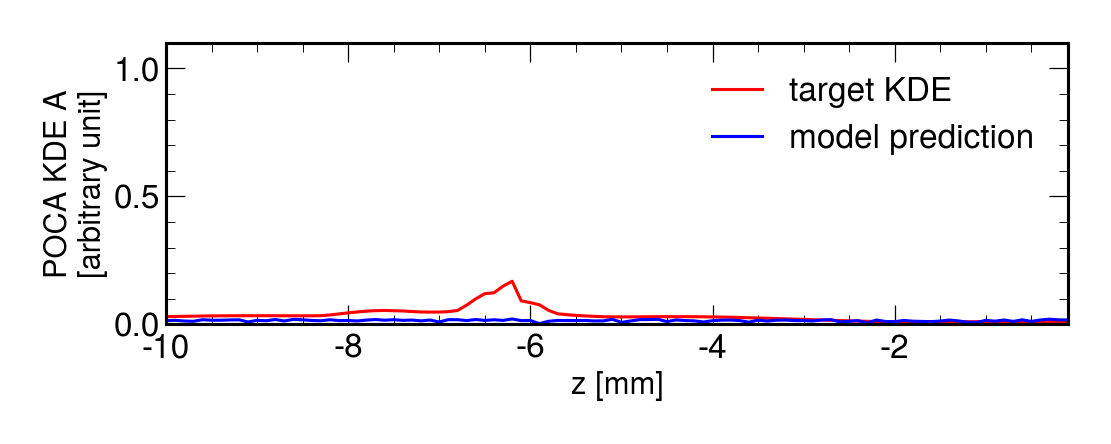

 Event (0) -- Interval (10) -- ymax ( 1.23) 


<IPython.core.display.Javascript object>


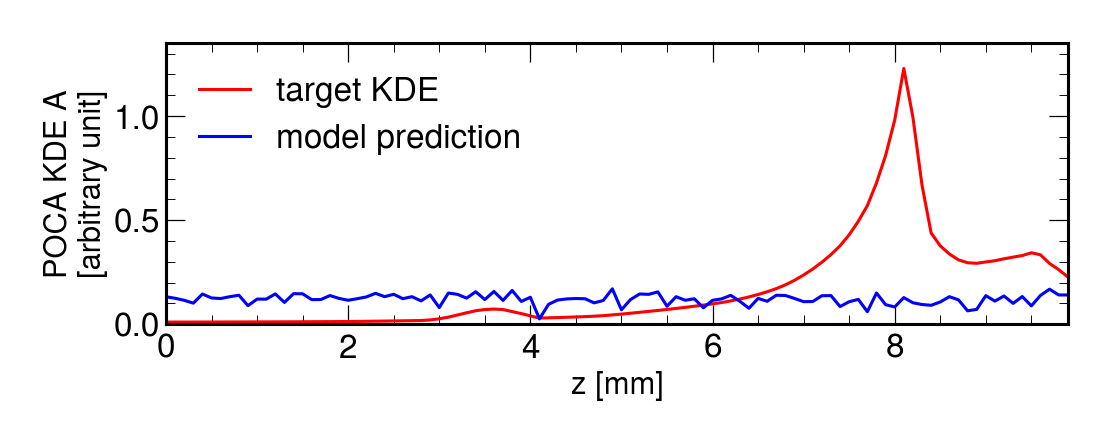

 Event (0) -- Interval (11) -- ymax ( 0.88) 


<IPython.core.display.Javascript object>


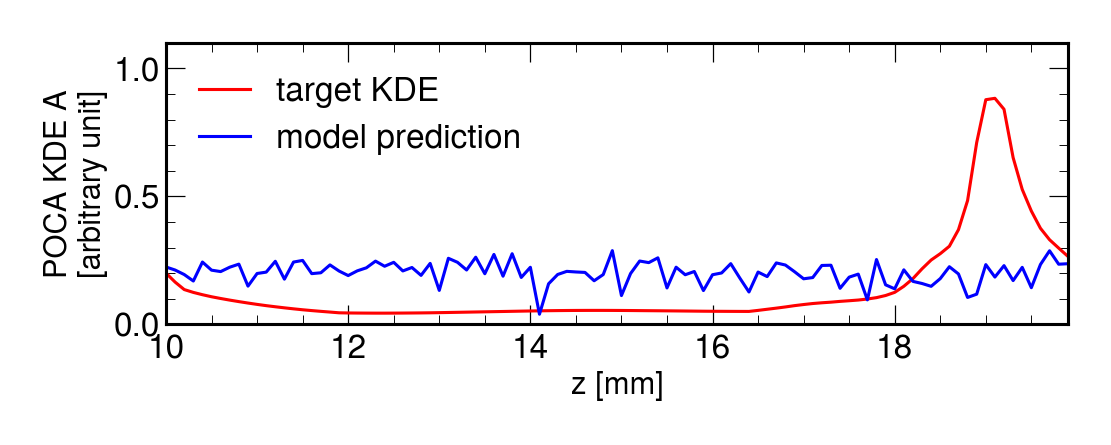

 Event (0) -- Interval (12) -- ymax ( 0.23) 


<IPython.core.display.Javascript object>


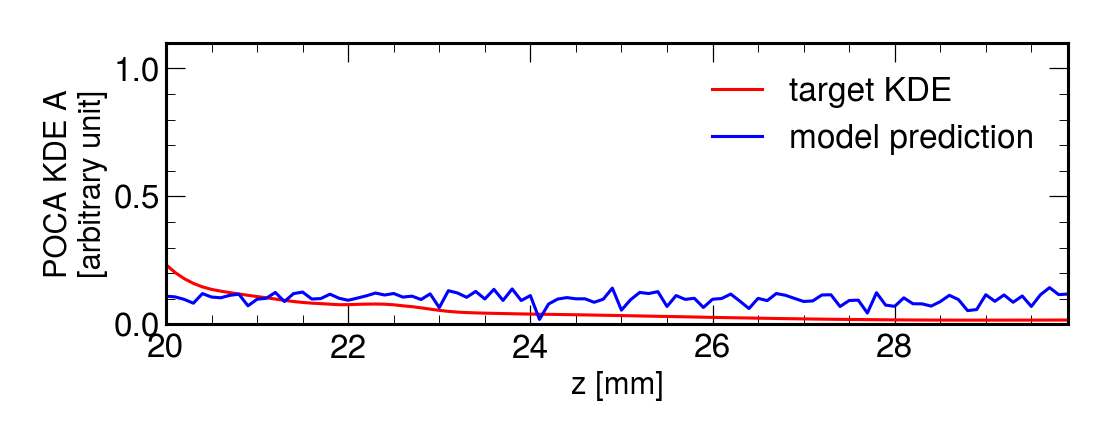

 Event (0) -- Interval (13) -- ymax ( 0.42) 


<IPython.core.display.Javascript object>


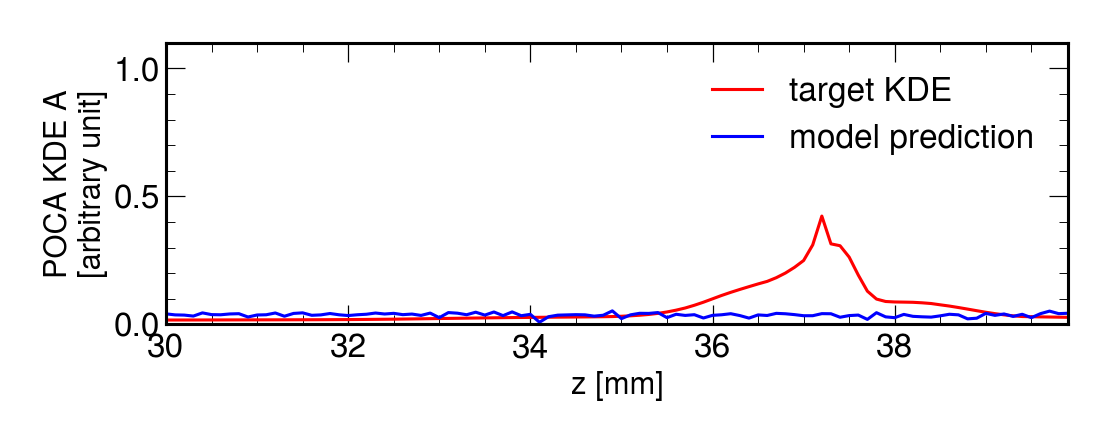

 Event (0) -- Interval (14) -- ymax ( 0.65) 


<IPython.core.display.Javascript object>


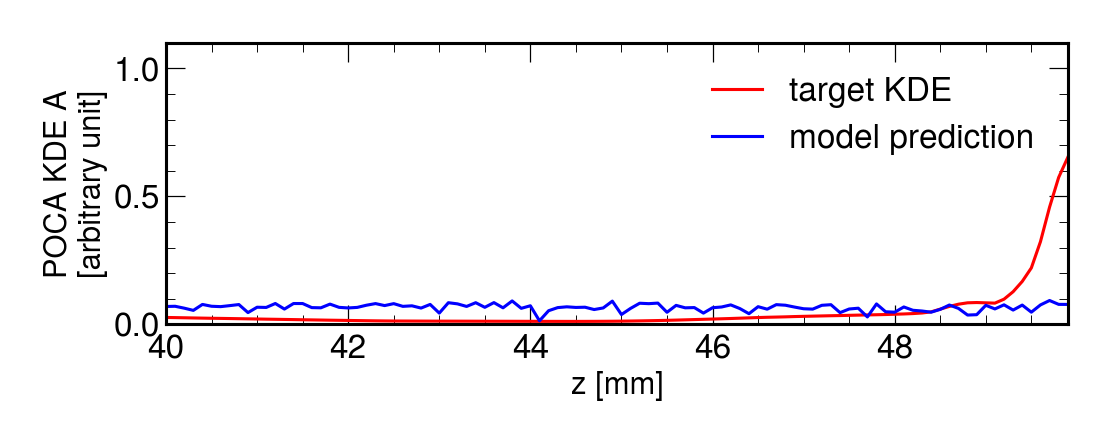

 Event (0) -- Interval (15) -- ymax ( 0.62) 


<IPython.core.display.Javascript object>


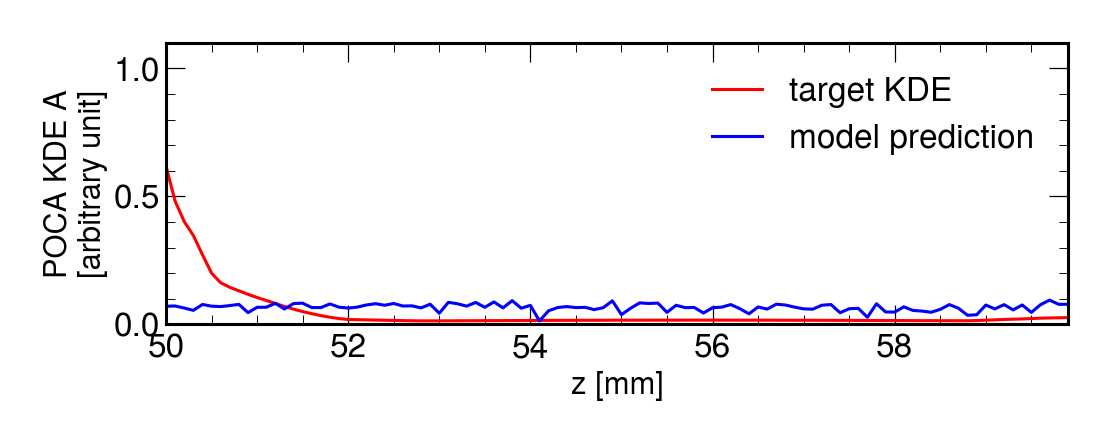

 Event (0) -- Interval (16) -- ymax ( 0.39) 


<IPython.core.display.Javascript object>


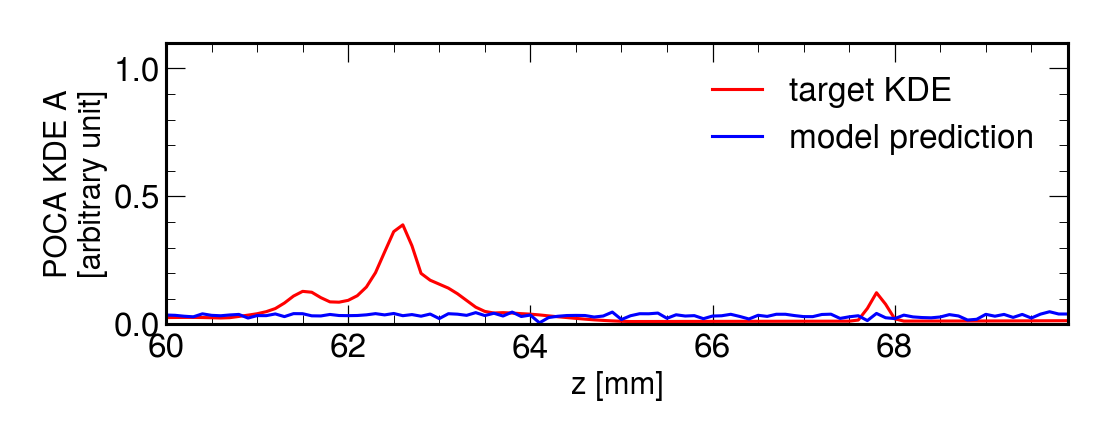

 Event (0) -- Interval (17) -- ymax ( 0.17) 


<IPython.core.display.Javascript object>


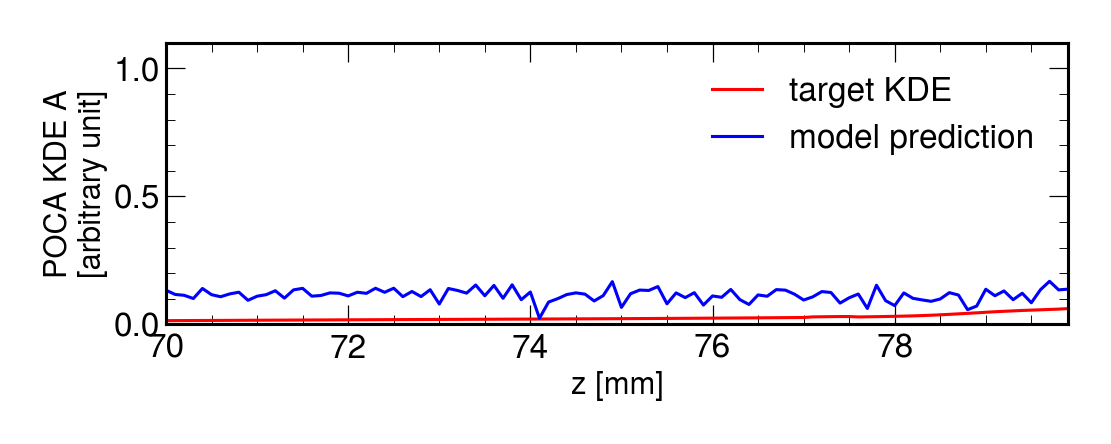

 Event (0) -- Interval (18) -- ymax ( 1.99) 


<IPython.core.display.Javascript object>


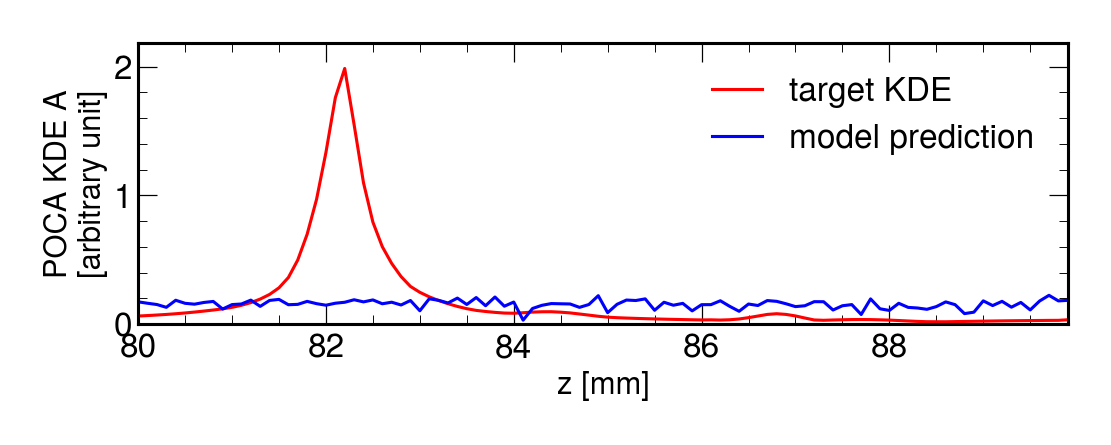

<IPython.core.display.Javascript object>


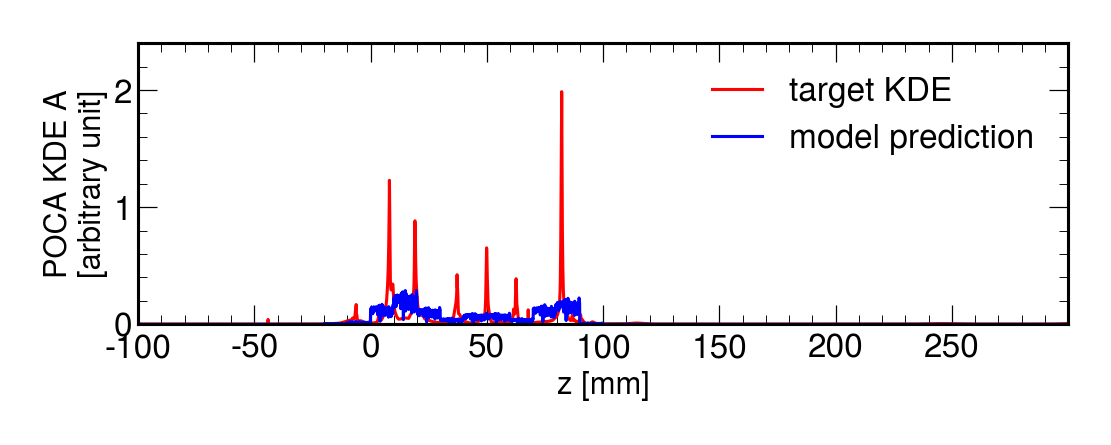


****************************************************************************************************


****************************************************************************************************
Saved testing plots in:

/data/home/sakar/ML_dir/pv_HLT1CPU_MinBiasMagUp_config_alpha__validPVs_5tracks__Intervals_100bins/tracks-to-KDE__IntervalsTrue__5Epochs__BatchSize32__YOUR_TAG_tutorial/plots

****************************************************************************************************


In [14]:
## Get the configuration (data + train tags) trained weights
weights_file = outPutFolder_weights / f'train_epoch_final.pyt'

test_model(model, test_loader, configs, weights_file, outPutFolder_plots, nEvts_display=1, display=True)

#  ___
#  STEP 7(a): update model weights

As many epochs may be needed to make the model converge it is often easier to split the training in $N$ iteration, where iteration $N'$ starts back from the weights of iteration $N'-1$.

In order to update the weights of a model, one can simply use the <strong>update_model_dict</strong> method with the pretrained dictionnary of weights as input.

In this tutorial, we use a pretrained dictionnary obtained after several hundreds of epochs of training on a large data sample of tens of thousands of events.

In [15]:
from utils.models_utils import update_model_dict

In [16]:
# Here we take one well trained model for illustration
preTrainedDict = "/share/lazy/sokoloff/ML/26August_testing_HalfDozen_first_learning_iter5A_200epochs_2em5_fullLHCbMC_scrubbedData/26August_testing_HalfDozen_first_learning_iter5A_200epochs_2em5_fullLHCbMC_scrubbedData_final.pyt"
# Update the model using the preTrained 
model = update_model_dict(model, preTrainedDict)

Current model dictionnary:
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias

Updating model dictionnary from:
  ==> /share/lazy/sokoloff/ML/26August_testing_HalfDozen_first_learning_iter5A_200epochs_2em5_fullLHCbMC_scrubbedData/26August_testing_HalfDozen_first_learning_iter5A_200epochs_2em5_fullLHCbMC_scrubbedData_final.pyt
Updated dictionnary:
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10   

#  ___
#  STEP 7(b): retrain model using previously trained weights (optional)

<strong>IMPORTANT:</strong> In order to store the new training results with different names and saving the training outputs in different folders, one needs to update the training tag and update the outputs directories.

In [17]:
# Update the training tag
train_tag = train_tag + "_update_dict"
# Importantly, also update the output directories
outPutFolder_weights, outPutFolder_plots = makeOutPutFolders(data_tag, train_tag, configs, CONFIG_FILE)

<IPython.core.display.Javascript object>


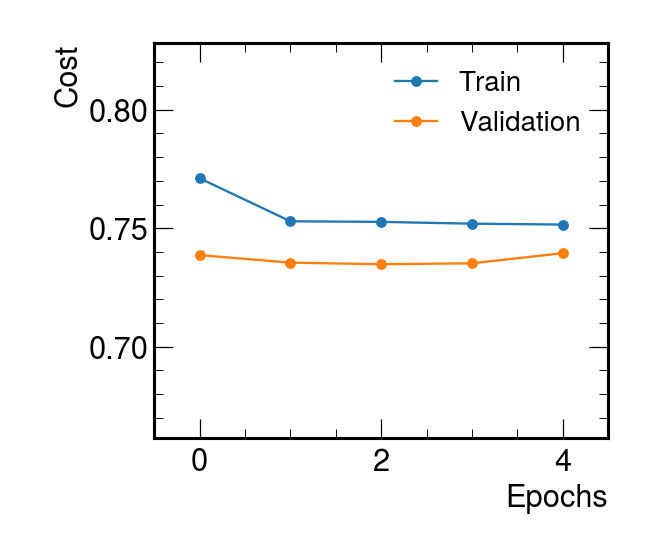

Number of batches: train = 2598, val = 322


Epochs:   0%|                                                                                                 …

Number of batches: train = 2598, val = 322


Training:   0%|                                                                                               …

Epoch 0: train=0.771081, val=0.738677, took 12.615 s


Training:   0%|                                                                                               …

Epoch 1: train=0.75293, val=0.735489, took 12.687 s


Training:   0%|                                                                                               …

Epoch 2: train=0.752682, val=0.734811, took 10.982 s


Training:   0%|                                                                                               …

Epoch 3: train=0.751922, val=0.735213, took 13.06 s


Training:   0%|                                                                                               …

Epoch 4: train=0.751555, val=0.739467, took 11.392 s

****************************************************************************************************
Saving model weights from final iteration in:

/data/home/sakar/ML_dir/pv_HLT1CPU_MinBiasMagUp_config_alpha__validPVs_5tracks__Intervals_100bins/tracks-to-KDE__IntervalsTrue__5Epochs__BatchSize32__YOUR_TAG_tutorial_update_dict/weights/train_epoch_final.pyt

****************************************************************************************************
Saving training plots in:

/data/home/sakar/ML_dir/pv_HLT1CPU_MinBiasMagUp_config_alpha__validPVs_5tracks__Intervals_100bins/tracks-to-KDE__IntervalsTrue__5Epochs__BatchSize32__YOUR_TAG_tutorial_update_dict/plots

****************************************************************************************************


In [18]:
train_model(model, loss, opt, train_loader, valid_loader, configs, outPutFolder_weights, outPutFolder_plots)

#  ___
#  STEP 7(c): test our model with a well trained set of weights

As one can see comparing to the outputs of the test from the initial trained and a well trained model, the predictions are visually in good agreement!  

****************************************************************************************************

 Event (0) 

 Event (0) -- Interval (9) -- ymax ( 0.17) 


<IPython.core.display.Javascript object>


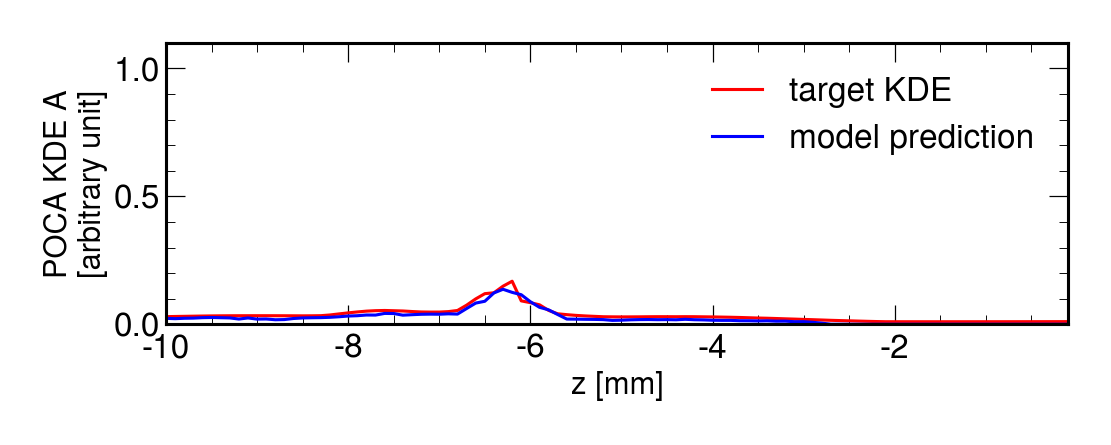

 Event (0) -- Interval (10) -- ymax ( 1.23) 


<IPython.core.display.Javascript object>


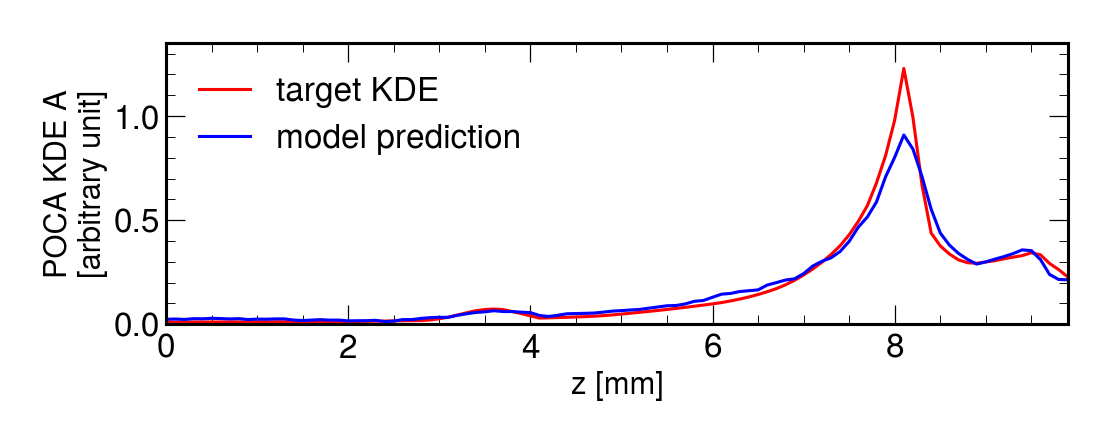

 Event (0) -- Interval (11) -- ymax ( 1.08) 


<IPython.core.display.Javascript object>


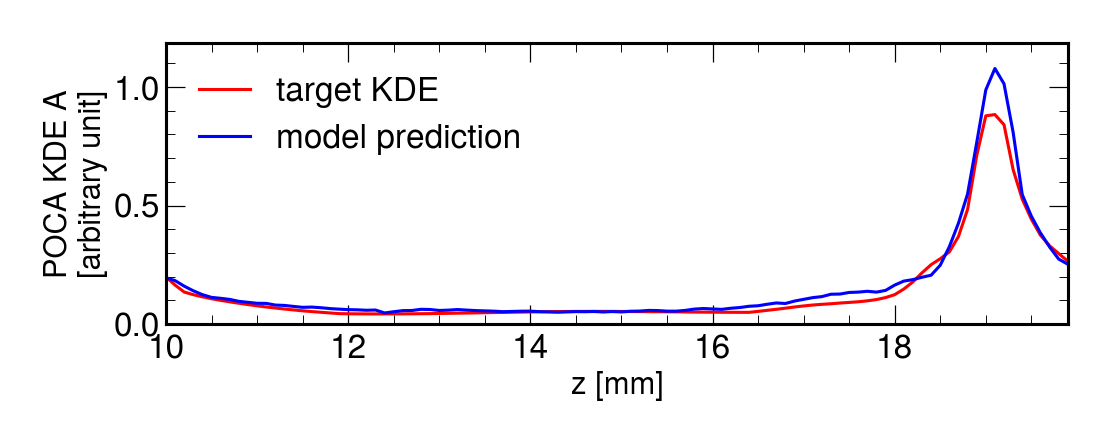

 Event (0) -- Interval (12) -- ymax ( 0.24) 


<IPython.core.display.Javascript object>


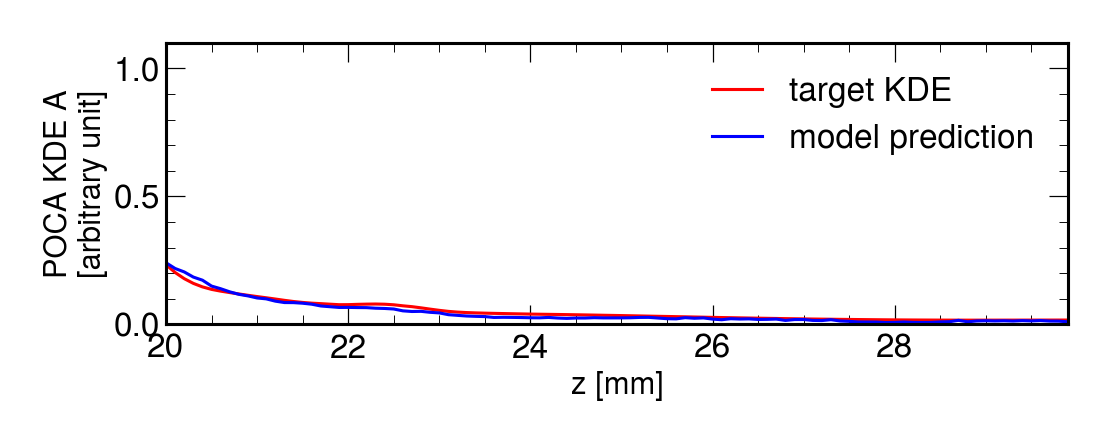

 Event (0) -- Interval (13) -- ymax ( 0.42) 


<IPython.core.display.Javascript object>


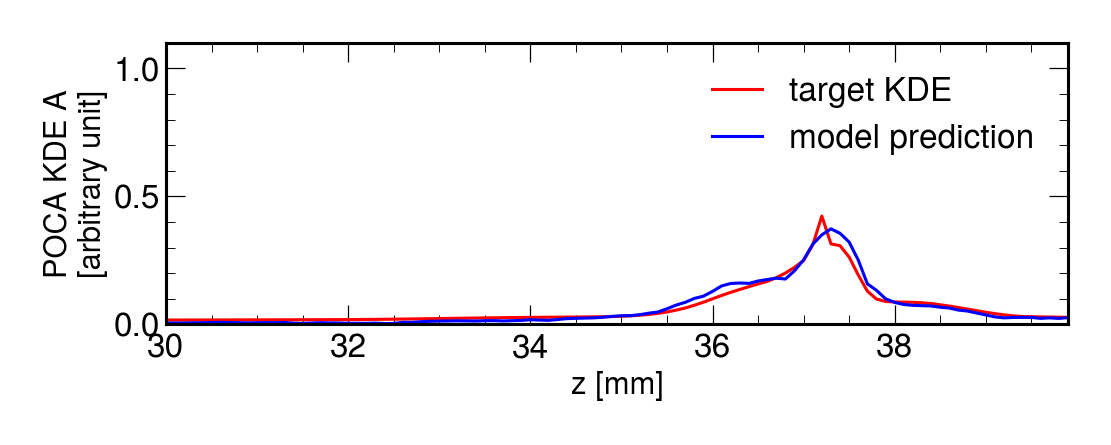

 Event (0) -- Interval (14) -- ymax ( 0.66) 


<IPython.core.display.Javascript object>


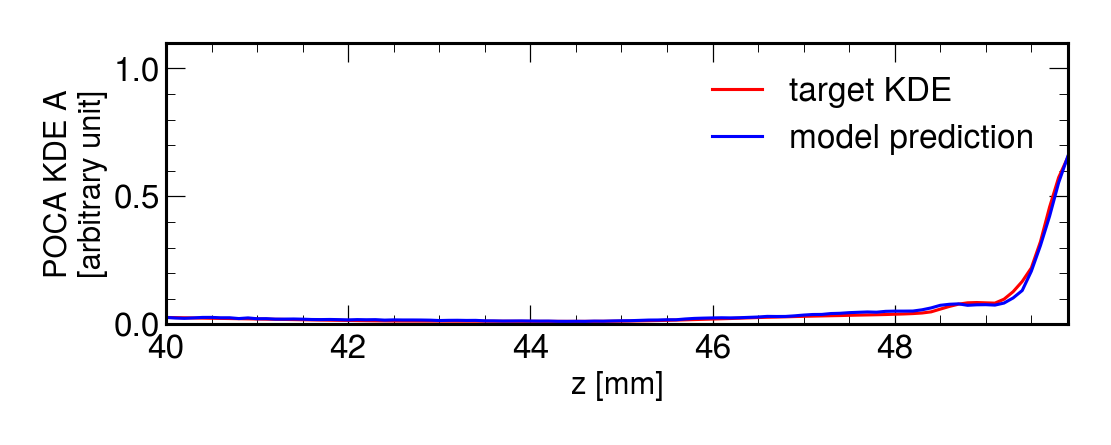

 Event (0) -- Interval (15) -- ymax ( 0.62) 


<IPython.core.display.Javascript object>


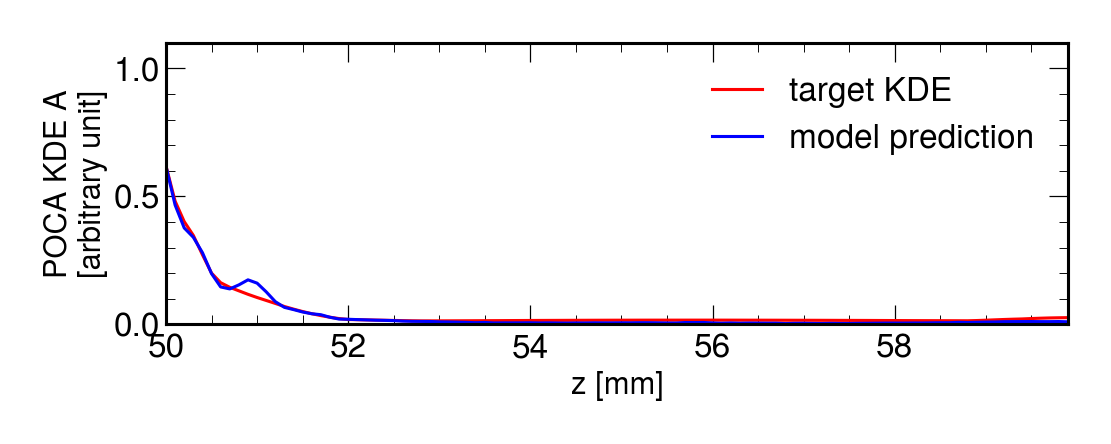

 Event (0) -- Interval (16) -- ymax ( 0.39) 


/data/home/sakar/pv-finder_v2/utils/plotting_utils.py:231: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>


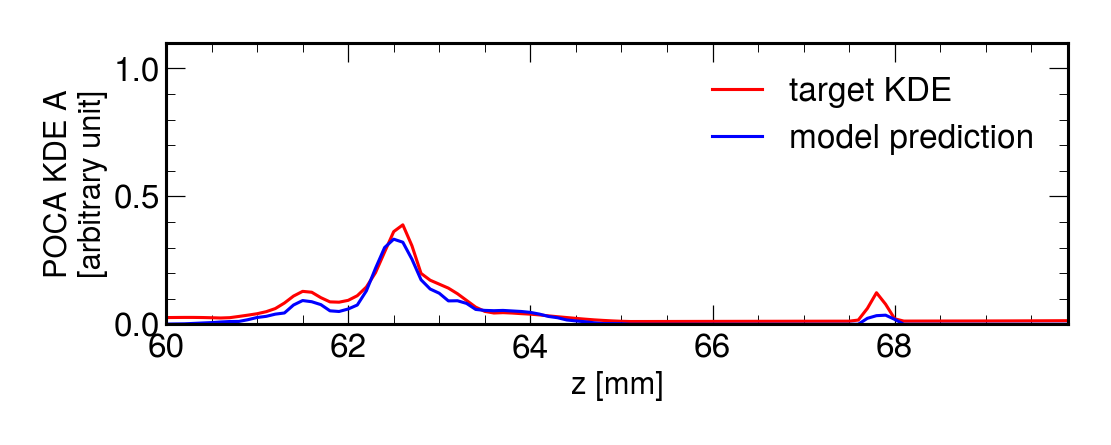

 Event (0) -- Interval (18) -- ymax ( 1.99) 


<IPython.core.display.Javascript object>


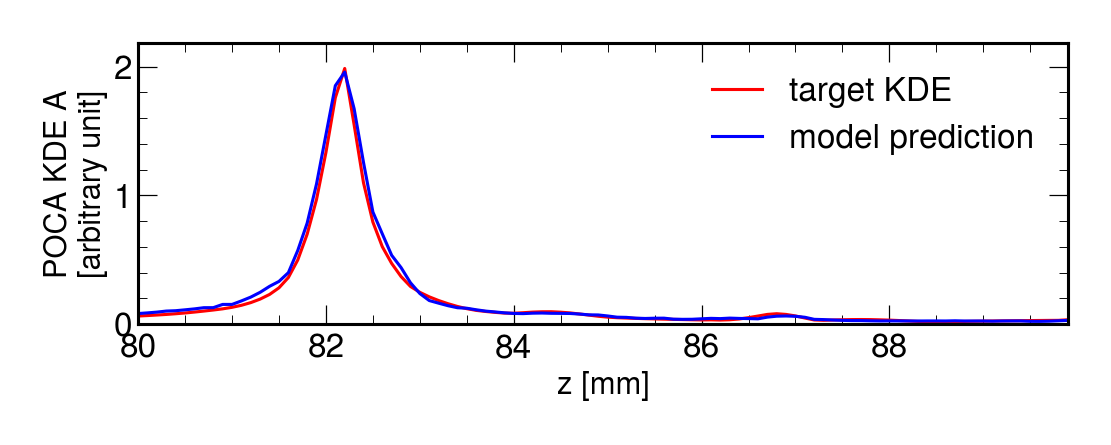

<IPython.core.display.Javascript object>


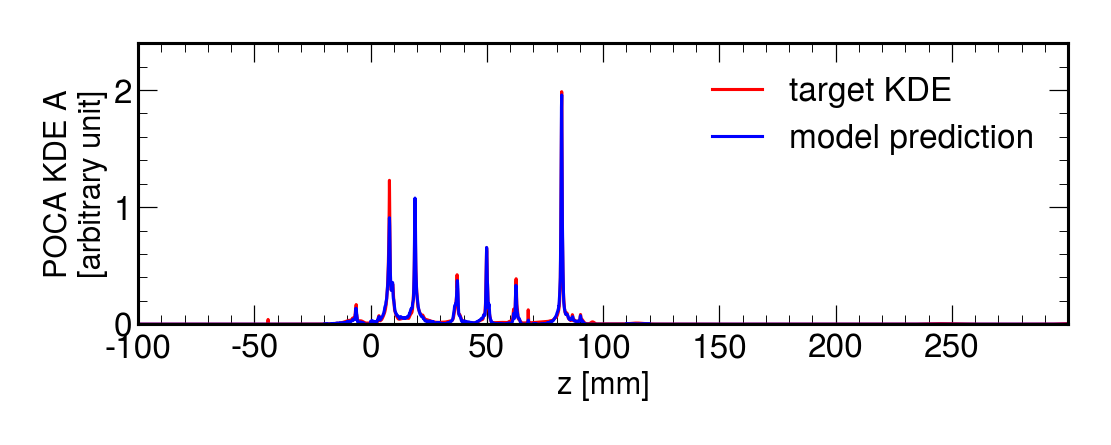


****************************************************************************************************


****************************************************************************************************
Saved testing plots in:

/data/home/sakar/ML_dir/pv_HLT1CPU_MinBiasMagUp_config_alpha__validPVs_5tracks__Intervals_100bins/tracks-to-KDE__IntervalsTrue__5Epochs__BatchSize32__YOUR_TAG_tutorial_update_dict/plots

****************************************************************************************************


In [19]:
## Get the configuration (data + train tags) trained weights
weights_file = outPutFolder_weights / f'train_epoch_final.pyt'

test_model(model, test_loader, configs, weights_file, outPutFolder_plots, nEvts_display=1, display=True)